We will first start with the necessary imports. For this project, we will need NLTK (for nlp), Gensim (for Word2Vec), SkLearn (for a clustering algorithm), Pandas and Numby (for data structures and processing), and some other libraries that will will need.

In [140]:
import nltk.data;

from gensim.models import word2vec;

from sklearn.cluster import KMeans;
from sklearn.neighbors import KDTree;

import pandas as pd;
import numpy as np;

import os;
import re;
import logging;
import sqlite3;
import time;
import sys;
import multiprocessing;
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt; 

From NLTK, we need to download the package "Punkt", which contains a module for obtaining sentences from a text. The package needs to be downloaded first.

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ravishchawla/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

The dataset I am using is the Reddit May2015 Comments data, avalaible on Kaggle here: http://kaggle.com/reddit/reddit-comments-may-2015

Since the data is in a .sqlite format, we will open up a sql connection to read it from.

In [9]:
sql_con = sqlite3.connect('/mnt/big/data/database.sqlite')

As a note, the dataset is very large in size (8 gb compressed / 30 gb uncompressed). I suggest that you use a machine that has sufficient RAM for processing. For my implementation, I ran the notebook on an AWS P4.2xLarge instance, with 60GB RAM.

In [11]:
start = time.time()
sql_data = pd.read_sql("SELECT body FROM May2015", sql_con);
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 82.60828137397766 secs


In [53]:
total_rows = len(sql_data);
print(total_rows)

54504410


We see that there are around 55,000,000 individual comments in this dataset.

Using the Punkt package from NLTK, we obtain a String tokenizer. The tokenizer allows us to feed it comments and obtain individual sentences in it. It'll be used as part of pre-processing.

In [4]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle');

The next function will be called on the comments, and will clean the data. We will apply several pre-processing steps to it.

1. Remove all escape-tabs and escape-newlines
2. Remove all non symbol characters (except for the dot)
3. Normalize spaces to a single character
4. Remove leading and trailing spaces
5. Tokenizing the text into sentences

Because it takes a long time to clean the entire comments data, the function has been written to take a file name as an argument. Instead of saving the cleaned text in memory, it will be written to this file instead, to help avoid a kernel crash in case the process runs out of memory.

In [29]:
def clean_text(all_comments, out_name):
    
    out_file = open(out_name, 'w');
    
    for pos in range(len(all_comments)):
    
        #Get the comment
        val = all_comments.iloc[pos]['body'];
        
        #Normalize tabs and remove newlines
        no_tabs = str(val).replace('\t', ' ').replace('\n', '');
        
        #Remove all characters except A-Z and a dot.
        alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs);
        
        #Normalize spaces to 1
        multi_spaces = re.sub(" +", " ", alphas_only);
        
        #Strip trailing and leading spaces
        no_spaces = multi_spaces.strip();
        
        #Normalize all charachters to lowercase
        clean_text = no_spaces.lower();
        
        #Get sentences from the tokenizer, remove the dot in each.
        sentences = tokenizer.tokenize(clean_text);
        sentences = [re.sub("[\.]", "", sentence) for sentence in sentences];
        
        #If the text has more than one space (removing single word comments) and one character, write it to the file.
        if len(clean_text) > 0 and clean_text.count(' ') > 0:
            for sentence in sentences:
                out_file.write("%s\n" % sentence)
                print(sentence);
                
        #Simple logging. At every 50000th step,
        #print the total number of rows processed and time taken so far, and flush the file.
        if pos % 50000 == 0:
            total_time = time.time() - start;
            sys.stdout.write('Completed ' + str(round(100 * (pos / total_rows), 2)) + '% - ' + str(pos) + ' rows in time ' + str(round(total_time / 60, 0)) + ' min & ' + str(round(total_time % 60, 2)) + ' secs\r');
            out_file.flush();
            break;
        
    out_file.close();

It took about 5 hours to clean the entire dataset. After having completed the pre-processing, the output file contained clean sentences with no symbols, uppercase letters, leading, trailing, or multi spaces, and escape charachters.

In [104]:
start = time.time();
clean_comments = clean_text(sql_data, '/mnt/big/out_full')
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 16183.129625082016 secs time 270.0 min & 41.12 secs


Now, we will train the Word2Vec model on the cleaned sentences.

In [ ]:
start = time.time();

#Set the logging format to get some basic updates.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',\
    level=logging.INFO)

# Set values for various parameters
num_features = 100;    # Dimensionality of the hidden layer representation
min_word_count = 40;   # Minimum word count to keep a word in the vocabulary
num_workers = multiprocessing.cpu_count();       # Number of threads to run in parallel set to total number of cpus.
context = 5          # Context window size (on each side)                                                       
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model. 
#The LineSentence object allows us to pass in a file name directly as input to Word2Vec,
#instead of having to read it into memory first.

print("Training model...");
model = word2vec.Word2Vec(LineSentence('/mnt/big/out_full_clean'), workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling);

# We don't plan on training the model any further, so calling 
# init_sims will make the model more memory efficient by normalizing the vectors in-place.
model.init_sims(replace=True);

# Save the model
model_name = "model_full_reddit";
model.save(model_name);

print('Total time: ' + str((time.time() - start)) + ' secs')

2017-09-05 20:10:37,714 : INFO : collecting all words and their counts
2017-09-05 20:10:37,715 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-09-05 20:10:37,808 : INFO : PROGRESS: at sentence #10000, processed 143622 words, keeping 15986 word types
2017-09-05 20:10:37,907 : INFO : PROGRESS: at sentence #20000, processed 288594 words, keeping 24352 word types


Training model...


2017-09-05 20:10:38,003 : INFO : PROGRESS: at sentence #30000, processed 432380 words, keeping 31260 word types
2017-09-05 20:10:38,099 : INFO : PROGRESS: at sentence #40000, processed 574738 words, keeping 37064 word types
2017-09-05 20:10:38,193 : INFO : PROGRESS: at sentence #50000, processed 714345 words, keeping 42447 word types
2017-09-05 20:10:38,288 : INFO : PROGRESS: at sentence #60000, processed 853496 words, keeping 46900 word types
2017-09-05 20:10:38,381 : INFO : PROGRESS: at sentence #70000, processed 987604 words, keeping 51254 word types
2017-09-05 20:10:38,477 : INFO : PROGRESS: at sentence #80000, processed 1130586 words, keeping 55442 word types
2017-09-05 20:10:38,572 : INFO : PROGRESS: at sentence #90000, processed 1271351 words, keeping 59242 word types
2017-09-05 20:10:38,669 : INFO : PROGRESS: at sentence #100000, processed 1414714 words, keeping 63028 word types
2017-09-05 20:10:38,763 : INFO : PROGRESS: at sentence #110000, processed 1549080 words, keeping 665

In [33]:
model = word2vec.Word2Vec.load('model_full_reddit');

Next, we obtain the Word Vectors for each word in the vocab, stored in a variable called 'syn0':

In [34]:
Z = model.wv.syn0;

In [37]:
print(Z[0].shape)
Z[0]

(100,)


array([-0.11665151, -0.049594  ,  0.11327834,  0.07592423, -0.04993806,
        0.1568293 , -0.1132786 ,  0.22942989,  0.00898544, -0.28502461,
        0.03516449,  0.08205829, -0.03942069, -0.00534692,  0.06644268,
       -0.00625445, -0.00066186, -0.07234078,  0.03497642, -0.01976413,
        0.01201833,  0.1050311 , -0.00342888, -0.18235329, -0.02376735,
       -0.02839357, -0.1606423 , -0.00285926,  0.13409872,  0.06622207,
       -0.10163352,  0.0105407 , -0.0997504 ,  0.06160791,  0.11051619,
        0.17395724,  0.04719392, -0.07631388, -0.10458953, -0.0071361 ,
       -0.01559975, -0.05712711,  0.02177166,  0.17927928, -0.05927899,
       -0.03273784,  0.04689875, -0.11919602, -0.10765067, -0.08047853,
        0.1568861 ,  0.07896987, -0.18372187,  0.07167481, -0.17768474,
        0.05764568, -0.04963266,  0.05483604,  0.10472295, -0.04929474,
        0.04694352, -0.14964867, -0.00282077, -0.11832199, -0.05498586,
        0.05160207,  0.0822202 ,  0.23181327,  0.08466525,  0.07

Looking at the word vector for the first word, we see a 100-element vector with values updated after training the neural network model.

Now, we will analyze the results of the algorithms in different ways, to see what we can do with Word2Vec. The first thing we will do is cluster the words using KMeans. Since the Words are represented as vectors, applying KMeans is easy to do since the clustering algorithm will simply look at differences between vectors (and centers).

In [60]:
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [61]:
start = time.time();
centers, clusters = clustering_on_wordvecs(Z, 50);
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 257.2132160663605 secs


In [62]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.10984086990356445 secs


Next, we get words in each cluster that are closest to the cluster center. To do this, we initialize a KDTree on the word vectors, and query it for the Top K words on each cluster center. Using the Index 2 word dictionary, we than correspond each word vector back to it's original word representation and add them to a dataframe for easier printiing.

In [120]:
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [121]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [122]:
top_words = get_top_words(model.wv.index2word, 5000, centers, Z);

In [123]:
top_words[0:20]

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19,Cluster #20,Cluster #21,Cluster #22,Cluster #23,Cluster #24,Cluster #25,Cluster #26,Cluster #27,Cluster #28,Cluster #29,Cluster #30,Cluster #31,Cluster #32,Cluster #33,Cluster #34,Cluster #35,Cluster #36,Cluster #37,Cluster #38,Cluster #39,Cluster #40,Cluster #41,Cluster #42,Cluster #43,Cluster #44,Cluster #45,Cluster #46,Cluster #47,Cluster #48,Cluster #49,Cluster #50
1,exwife,echando,csk,nymphs,slithers,benson,nedir,undermining,thingsthere,mallninjashit,cyklister,pltzjrhgif,thanksi,secretion,warbringer,weap,nightso,hmrc,buttermilk,rhineland,fastback,bellonas,materialism,archivehtml,badbadnotgood,trouwens,ranma,awesomenauts,missles,riverside,cucks,ambigram,valeur,ebenfalls,besler,hahahaah,turnigy,catainia,confine,eviscerated,appunto,oscillations,druddigon,interestingit,pleather,flemeth,noastre,chegou,nmap,rzg
2,tormentors,adecuada,mous,spiny,bobbed,welch,cevap,belittles,oddballs,swordorsheath,fyller,dhmeazkgif,dudei,corticosteroids,rattleclaw,godsword,nightit,commission,curd,macedonia,hardtop,gnars,scientism,dxdoiorg,thundercat,slechts,gintoki,homm,grenadiers,hampden,misogynist,antipattern,lalcool,verfahren,coyle,yaaaa,frsky,wpintheshower,expose,savaged,peggio,redshift,noibat,offputting,neoprene,odysseus,acasa,mestrado,plugin,zbc
3,ladyfriend,revisar,anderlecht,jellyfish,flapped,byrne,devam,pursues,thingsthey,treessuckingonthings,idioter,tjabjjlgif,heyi,hypertension,stoneforge,vagan,nightbut,fincen,soya,jordanian,cyl,meele,conceptualization,didthemarinerswincom,bjork,gebeurt,gosick,nwn,javelin,lakewood,mysoginistic,lpwo,choisi,wenigstens,boozer,ohhhhhhhhh,sanyo,xgykbfcd,supplant,overtaken,diritto,diffusion,slugma,importantbut,beaded,boromir,incepe,conseguiram,commandline,oyz
4,daugher,maravilloso,jaedong,lizards,wiggled,connelly,eka,defends,oddities,subredditsashashtags,fortsatt,drhiqrgifv,hahahai,corticosteroid,rakshasa,masamune,nightthis,ird,wasabi,burma,mkiv,udyrs,praxeology,blognavercom,yelawolf,meestal,xxxholic,skullgirls,ballista,decatur,tumblerina,antivaxxer,suivre,niemals,briere,ayye,jvc,gijose,rationalise,cannibalized,mantenere,perturbation,spiritomb,commonand,ultrafine,mordred,undeva,noite,xampp,vww
5,shipmates,tremenda,galatasaray,tadpoles,darted,mckay,olmu,denigrates,counterexamples,shubreddit,ordentligt,drhiqr,yesi,isotretinoin,nighthowler,veng,edcny,cmhc,buckwheat,sultanate,peugeot,swains,nihilism,inceptiondavepeducom,bangarang,eruit,idolmaster,dcuo,miniguns,pasadena,humourless,idiotbut,lacte,dennoch,haula,yaaaaa,boscam,ellesarisellendil,constrain,hounded,figlio,cmb,moltres,unproffesional,cowhide,moqorro,tocmai,acabou,winscp,qhw
6,wifeand,prioridad,huk,clownfish,scooting,dunne,saat,disrespects,gotchas,theydidthemonstermath,staden,imzhell,yeai,cipro,gravekeepers,danjuro,nightalso,underwriting,applesauce,macedonian,silverado,ulty,dialectic,blogcom,qotsa,vaker,adachi,titanfall,decimator,ashland,trannies,assholealso,devait,jedoch,wisniewski,nawww,emax,deckwash,verbalize,bested,soprattutto,spectroscopy,audino,irksome,peacoat,faramir,acestea,fugir,libc,vyt
7,friendyou,castigo,stephano,reindeer,bobbing,siegel,amk,sabotages,thigns,thingsjonsnowknows,metoder,adibprojpg,youstill,idiopathic,banefire,tyro,nightand,icbc,jalapeno,mughals,wrangler,dravens,universality,momspaghettiytmndcom,madvillainy,aardig,takahashi,firefall,machinegun,lexington,libtard,overexaggeration,vacances,daraus,cassels,yooooo,kenwood,japface,subvert,outvoted,scienza,capacitance,dedenne,importantedit,tulle,conquerer,scurt,risco,dmenu,qgc
8,sexlife,electorado,fener,caterpillars,wiggling,mcgrath,degil,victimizing,afscs,girlsmirin,saken,vwmingif,matei,hypoglycemia,thragtusk,weaps,nightedit,financing,chutney,rhodesia,supra,trynd,amorality,mainhtml,motown,gedrag,saki,terraria,needler,charleston,feminazi,antijoke,tudier,ndlich,osuna,

In [167]:
def display_cloud(cluster_num):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    #plt.figure()
    # recolor wordcloud and show
    # we could also give color_func=image_colors directly in the constructor
    plt.axis("off")
    plt.show()

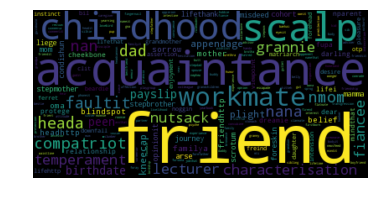

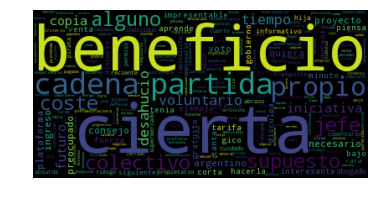

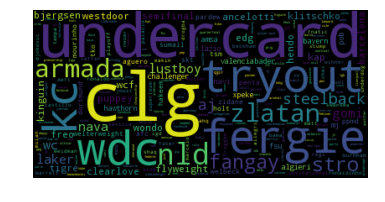

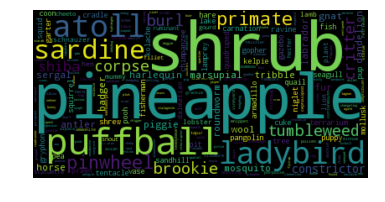

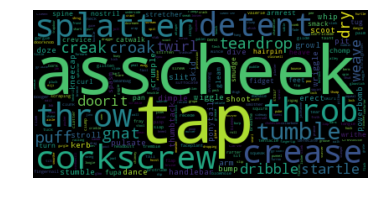

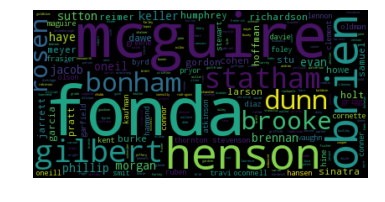

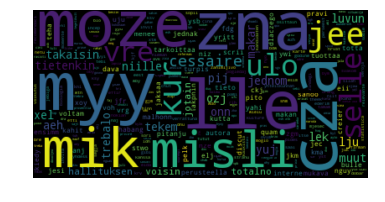

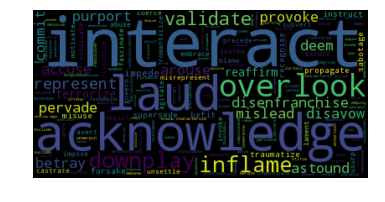

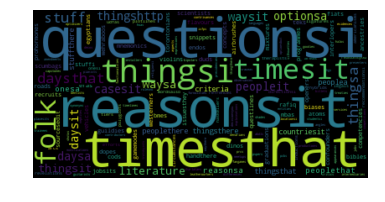

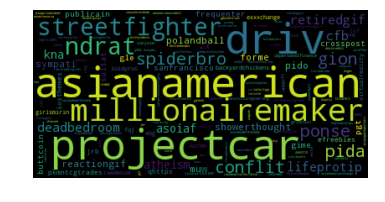

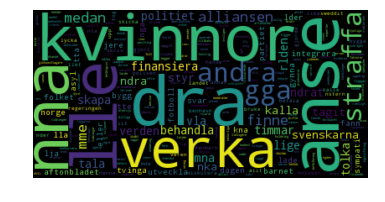

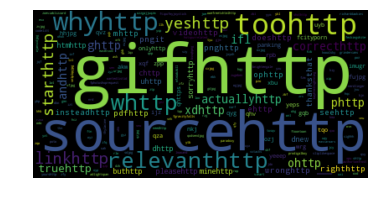

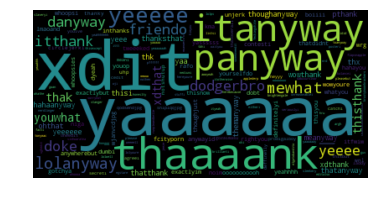

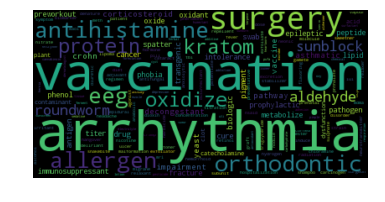

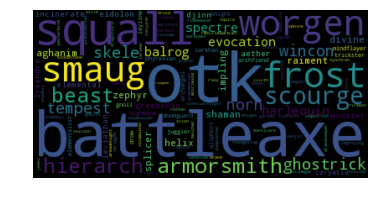

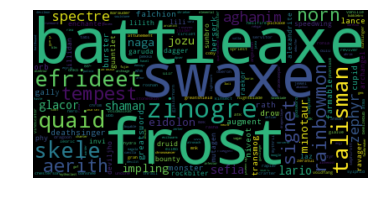

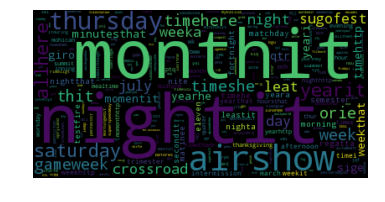

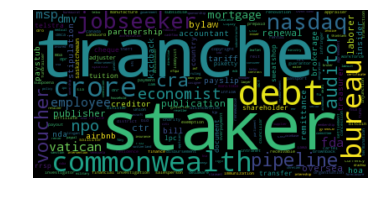

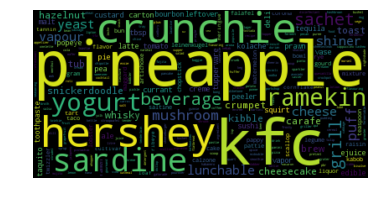

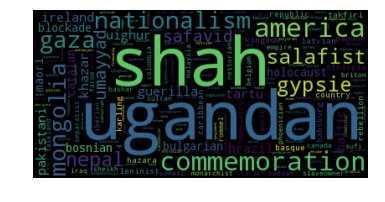

In [171]:
for i in range(20):
    display_cloud(i+1)

What else can we do with Word Vectors? Gensim provides some built in functions for us to play with. We can use analogies to see word associations. For instance, King is to Woman as Queen is to _ , we get:

In [73]:
model.wv.most_similar_cosmul(positive=['king', 'woman'], negative=['queen'])

[('gentleman', 0.8628610968589783),
 ('man', 0.8114351034164429),
 ('murderer', 0.8090904951095581),
 ('felon', 0.80820232629776),
 ('policeman', 0.808160662651062),
 ('cop', 0.802880585193634),
 ('guy', 0.8000115752220154),
 ('conman', 0.7993671894073486),
 ('zimmerman', 0.7991874814033508),
 ('lawman', 0.7969103455543518)]

Although 'man' is not the first keyword here, some of the other words also fall in the same category.

In [82]:
model.wv.doesnt_match("apple microsoft samsung tesla".split())

'tesla'

In [83]:
model.wv.doesnt_match("trump clinton sanders obama".split())

'trump'

In [87]:
model.wv.doesnt_match("joffrey cersei tywin lannister jon".split())

'jon'

In [92]:
model.wv.similar_by_word('hodor')

[('meera', 0.8404712677001953),
 ('coldhands', 0.835121750831604),
 ('bloodraven', 0.8288142681121826),
 ('benjen', 0.8221811056137085),
 ('sarella', 0.8137876987457275),
 ('wylla', 0.8090651035308838),
 ('patchface', 0.8021899461746216),
 ('sweetrobin', 0.8003571033477783),
 ('bran', 0.7983769178390503),
 ('craster', 0.7961913347244263)]

In [91]:
model.wv.similar_by_word('musk')

[('elon', 0.9014049768447876),
 ('musks', 0.725604772567749),
 ('tesla', 0.6728091239929199),
 ('solarcity', 0.648371696472168),
 ('nikola', 0.6350993514060974),
 ('bezos', 0.6285077333450317),
 ('wozniak', 0.6269021034240723),
 ('woz', 0.6040015816688538),
 ('spacex', 0.6011152863502502),
 ('buffett', 0.6006543636322021)]

In [110]:
model.wv.similar_by_word('apple')

[('iwatch', 0.7271769642829895),
 ('android', 0.7153875231742859),
 ('blackberry', 0.712940514087677),
 ('iphone', 0.6994314789772034),
 ('huawei', 0.6864886283874512),
 ('motorola', 0.6803016662597656),
 ('crapple', 0.6710368394851685),
 ('microsoft', 0.6698368787765503),
 ('urbane', 0.6604104042053223),
 ('micromax', 0.6360206007957458)]

Results show how effective Word Vectors are in understanding context between words. We see that the algorithm is easily able to identify words that are based on similar concepts, even though they are less likely to appear in the same sentences. The reason for this is because these words are more likely to have similar labels, which forces their vectors to train into values that can predict those labels correctly.